In [152]:
import os
import pandas as pd
import torch
from darts import TimeSeries
from darts.models import NHiTSModel
from darts.utils.likelihood_models import GaussianLikelihood
from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl


# Define the columns to include in the new DataFrame
order_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Order Management CPU Usage',
    'Order Management Memory Usage',
    'Order Management Request Count',
    'Order Management 5xx Failures',
    'Order Management Pod Count'
]
product_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Product Catalog CPU Usage',
    'Product Catalog Memory Usage',
    'Product Catalog Request Count',
    'Product Catalog 5xx Failures',
    'Product Catalog Pod Count'
]
shipping_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Shipping Logistics CPU Usage',
    'Shipping Logistics Memory Usage',
    'Shipping Logistics Request Count',
    'Shipping Logistics 5xx Failures',
    'Shipping Logistics Pod Count'
]
user_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'User Account CPU Usage',
    'User Account Memory Usage',
    'User Account Request Count',
    'User Account 5xx Failures',
    'User Account Pod Count'
]
reviews_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Review Rating CPU Usage',
    'Review Rating Memory Usage',
    'Review Rating Request Count',
    'Review Rating 5xx Failures',
    'Review Rating Pod Count'
]
payment_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Payment Processing CPU Usage',
    'Payment Processing Memory Usage',
    'Payment Processing Request Count',
    'Payment Processing 5xx Failures',
    'Payment Processing Pod Count'
]

file_path = '~/Downloads/Collected Data - 24 Sep 23:59:00.csv'

# Creating dataframes for each service
order_df = pd.read_csv(file_path, usecols=order_columns_to_include)
product_df = pd.read_csv(file_path, usecols=product_columns_to_include)
user_df = pd.read_csv(file_path, usecols=user_columns_to_include)
reviews_df = pd.read_csv(file_path, usecols=reviews_columns_to_include)
shipping_df = pd.read_csv(file_path, usecols=shipping_columns_to_include)
payment_df = pd.read_csv(file_path, usecols=payment_columns_to_include)

order_df.fillna(0, inplace=True)
product_df.fillna(0, inplace=True)
user_df.fillna(0, inplace=True)
reviews_df.fillna(0, inplace=True)
shipping_df.fillna(0, inplace=True)
payment_df.fillna(0, inplace=True)


# Convert 'Timestamp [ms]' to datetime and set it as the index
order_df['Time'] = pd.to_datetime(order_df['Time'])
order_df.set_index('Time', inplace=True)
order_df['Time'] = order_df.index
order_df.head()

product_df['Time'] = pd.to_datetime(product_df['Time'])
product_df.set_index('Time', inplace=True)
product_df['Time'] = product_df.index
product_df.head()

user_df['Time'] = pd.to_datetime(user_df['Time'])
user_df.set_index('Time', inplace=True)
user_df['Time'] = user_df.index
user_df.head()

reviews_df['Time'] = pd.to_datetime(reviews_df['Time'])
reviews_df.set_index('Time', inplace=True)
reviews_df['Time'] = reviews_df.index
reviews_df.head()

shipping_df['Time'] = pd.to_datetime(shipping_df['Time'])
shipping_df.set_index('Time', inplace=True)
shipping_df['Time'] = shipping_df.index
shipping_df.head()

payment_df['Time'] = pd.to_datetime(payment_df['Time'])
payment_df.set_index('Time', inplace=True)
payment_df['Time'] = payment_df.index
payment_df.head()

payment_df.head()

,Cluster CPU,Cluster Memory,Payment Processing CPU Usage,Payment Processing Memory Usage,Payment Processing Pod Count,Payment Processing Request Count,Payment Processing 5xx Failures,Time
Time,,,,,,,,
2024-08-21 00:00:00,18.7,26.8,57.3,34.1,3,4424.0,0.0,2024-08-21 00:00:00
2024-08-21 00:01:00,19.8,27.0,72.6,34.1,3,4912.0,0.0,2024-08-21 00:01:00
2024-08-21 00:02:00,20.8,27.0,49.4,34.1,3,5118.0,0.0,2024-08-21 00:02:00
2024-08-21 00:03:00,20.7,27.0,54.6,34.2,3,4684.0,0.0,2024-08-21 00:03:00
2024-08-21 00:04:00,20.3,27.0,51.0,34.2,3,4378.0,0.0,2024-08-21 00:04:00


In [156]:

# Define model arguments as a dictionary (JSON-like structure)
nhits_model_args = {
    "input_chunk_length": 1440,  # Past 24 hours time steps as input
    "output_chunk_length": 480,  # Predict the next 8 hours time steps
    "n_epochs": 40,              # Number of training epochs
    "random_state": 42,           # For reproducibility
    "likelihood": GaussianLikelihood(),  # Likelihood model for probabilistic forecasts
    "batch_size": 64,
    "lr_scheduler_cls": torch.optim.lr_scheduler.ExponentialLR,
    "lr_scheduler_kwargs": {"gamma": 0.999},
    "save_checkpoints": True,
    "force_reset": True,
    "dropout": 0.15,
    "optimizer_kwargs": {"lr": 1e-3}  # Define your learning rate here
}

# Define early stopping arguments
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 3,
    "mode": "min",
    "strict": True,
    "verbose": True,
}

# Set the log directory where logs will be saved
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Create a TensorBoardLogger
logger = TensorBoardLogger(log_dir, name="microservices_all_models")

# Define your trainer arguments
pl_trainer_kwargs = {
    "max_epochs": 40,
    "logger": logger,
    "callbacks": [
        EarlyStopping(**early_stopping_args)
    ]
}

# Directory where models will be saved
model_dir = os.path.expanduser("~/Documents/models/")
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist


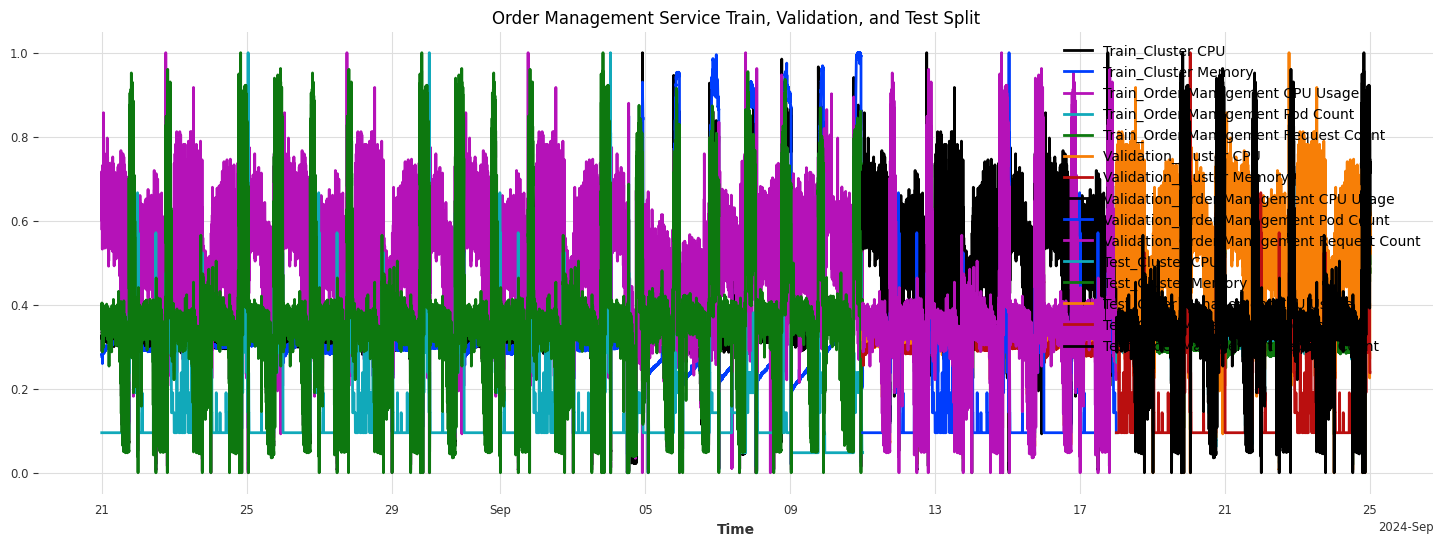

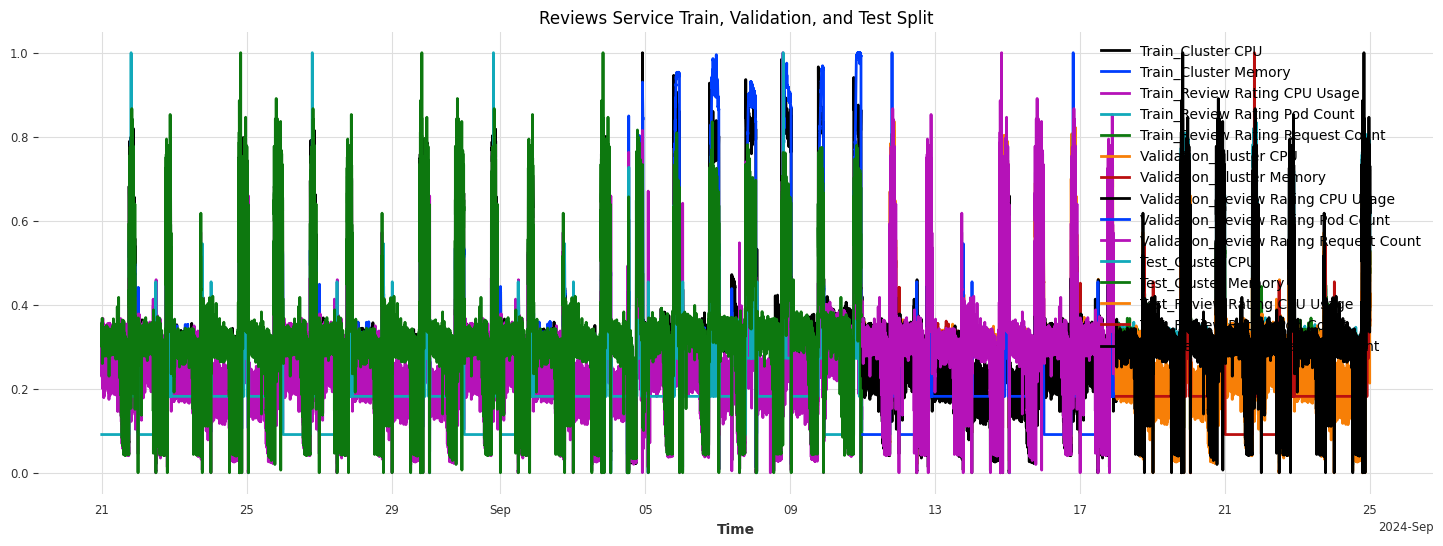

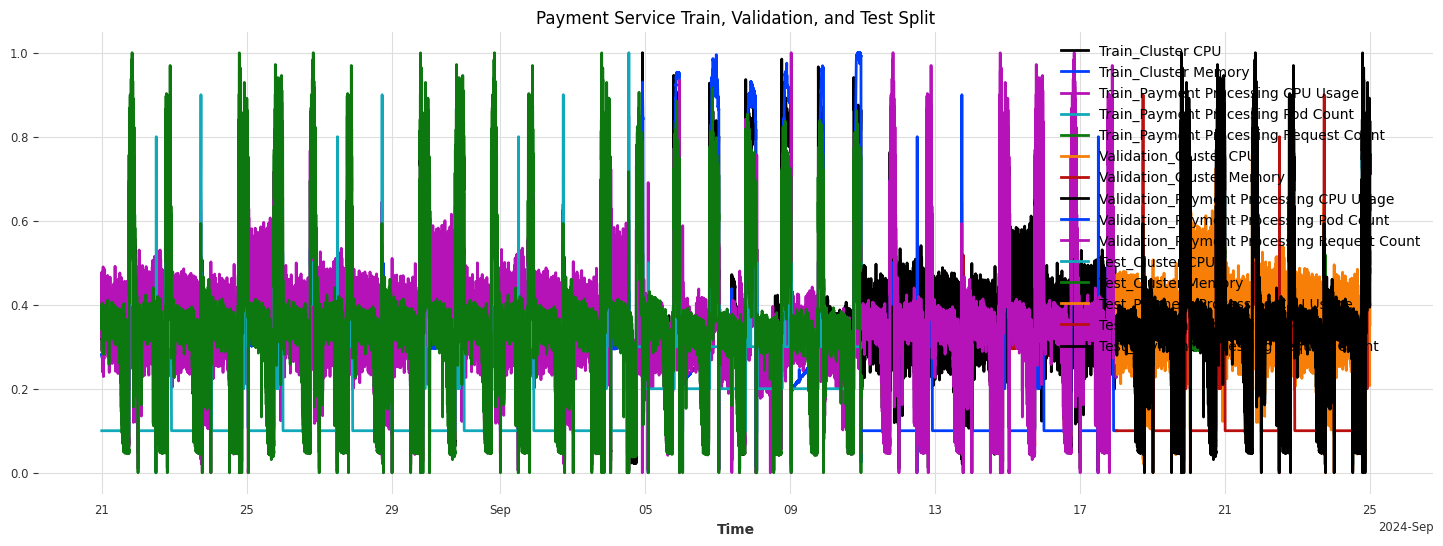

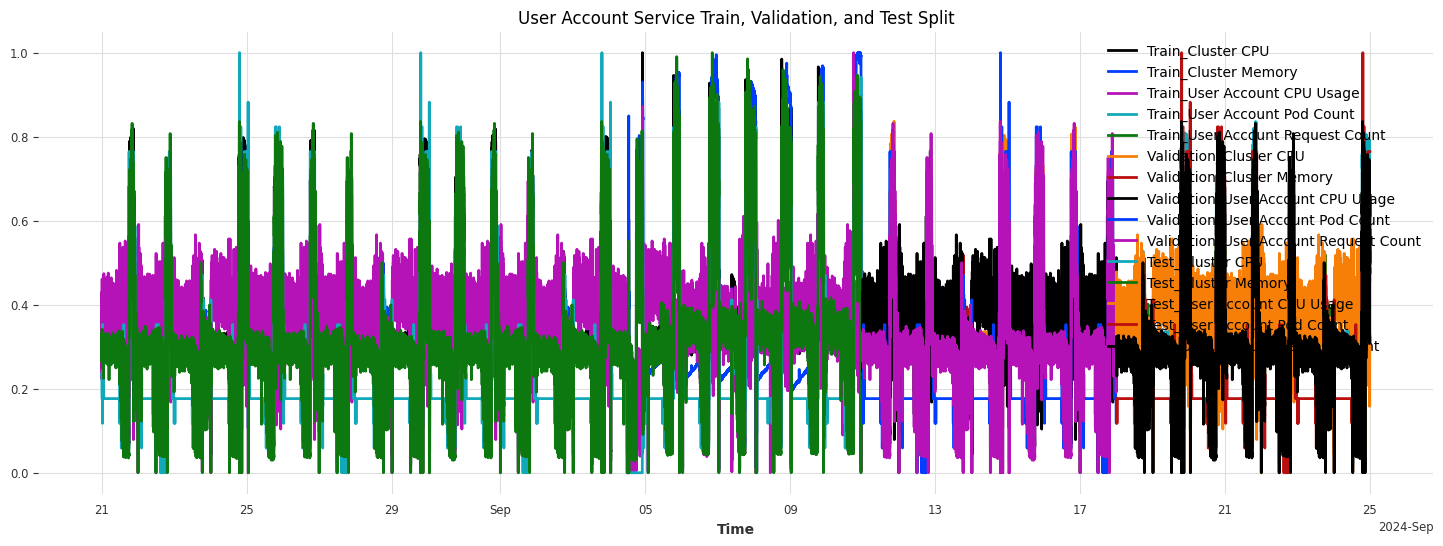

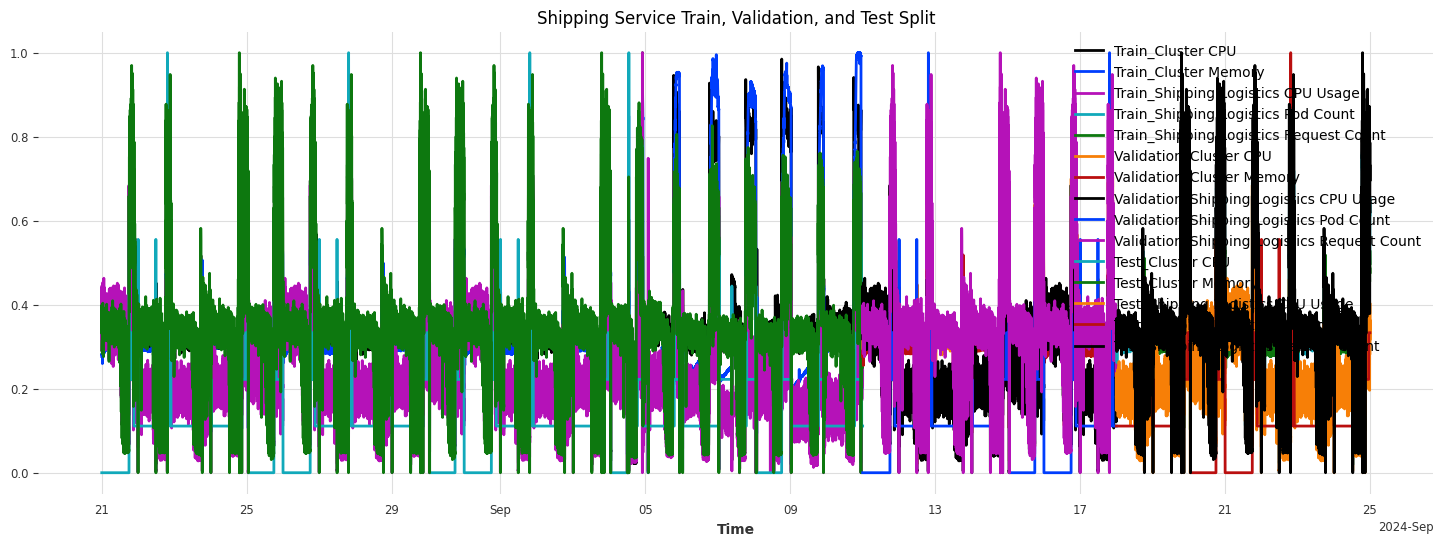

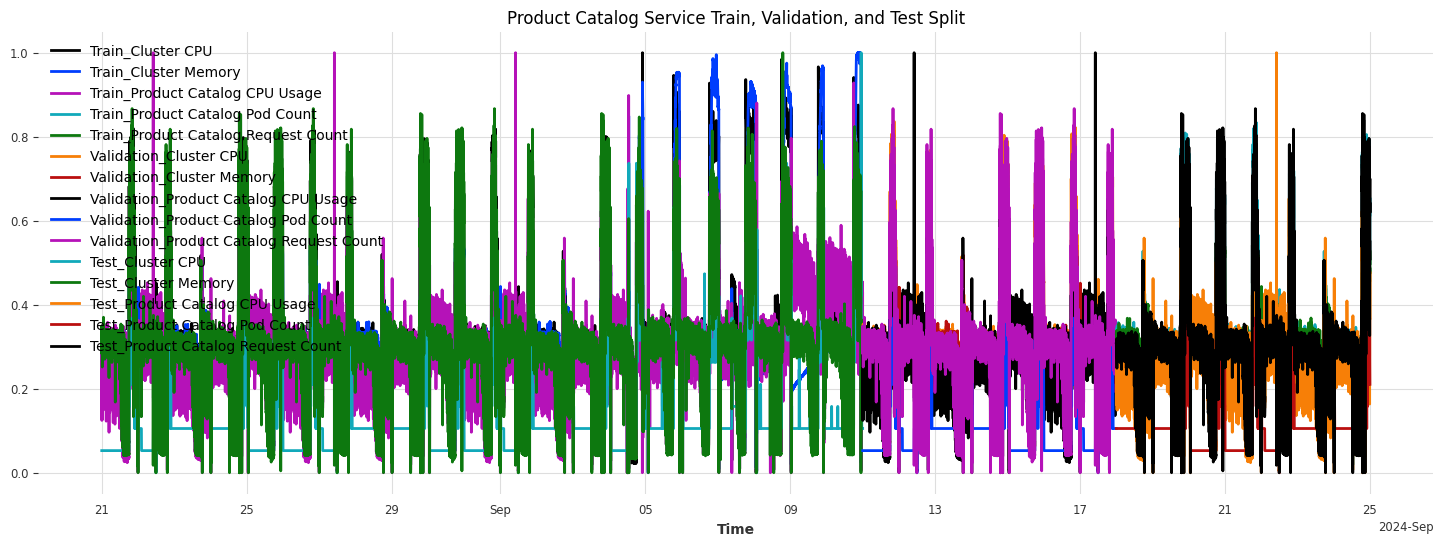

In [157]:
# 1. Order Management Service
series_cluster_cpu_order = TimeSeries.from_dataframe(order_df, 'Time', 'Cluster CPU')
series_cluster_memory_order = TimeSeries.from_dataframe(order_df, 'Time', 'Cluster Memory')
series_order_cpu = TimeSeries.from_dataframe(order_df, 'Time', 'Order Management CPU Usage')
series_order_memory = TimeSeries.from_dataframe(order_df, 'Time', 'Order Management Memory Usage')
series_order_pod_count = TimeSeries.from_dataframe(order_df, 'Time', 'Order Management Pod Count')
series_order_request_count = TimeSeries.from_dataframe(order_df, 'Time', 'Order Management Request Count')
series_order_5xx_failures = TimeSeries.from_dataframe(order_df, 'Time', 'Order Management 5xx Failures')

# Normalize/Scale the data
scaler = Scaler(MinMaxScaler())
series_cluster_cpu_order_scaled = scaler.fit_transform(series_cluster_cpu_order)
series_cluster_memory_order_scaled = scaler.fit_transform(series_cluster_memory_order)
series_order_cpu_scaled = scaler.fit_transform(series_order_cpu)
series_order_memory_scaled = scaler.fit_transform(series_order_memory)
series_order_pod_count_scaled = scaler.fit_transform(series_order_pod_count)
series_order_request_count_scaled = scaler.fit_transform(series_order_request_count)
series_order_5xx_failures_scaled = scaler.fit_transform(series_order_5xx_failures)

# Stack the time series for multi-target forecasting
multivariate_series_order = (
    series_cluster_cpu_order_scaled.stack(series_cluster_memory_order_scaled)
    .stack(series_order_cpu_scaled)
    # .stack(series_order_memory_scaled)
    .stack(series_order_pod_count_scaled)
    .stack(series_order_request_count_scaled)
    # .stack(series_order_5xx_failures_scaled)
)

# Train/Test/Validation Split
train_size = 0.6  # 60% for training
val_size = 0.2  # 20% for validation
train_val_cutoff = int(train_size * len(multivariate_series_order))
val_test_cutoff = int((train_size + val_size) * len(multivariate_series_order))

# Splitting the multivariate series for Order Management
train_series_order = multivariate_series_order[:train_val_cutoff]
val_series_order = multivariate_series_order[train_val_cutoff:val_test_cutoff]
test_series_order = multivariate_series_order[val_test_cutoff:]

plt.figure(figsize=(18, 6))
train_series_order.plot(label='Train')
val_series_order.plot(label='Validation')
test_series_order.plot(label='Test')
plt.title("Order Management Service Train, Validation, and Test Split")
plt.legend()
plt.show()


# 2. Reviews Service
series_cluster_cpu_reviews = TimeSeries.from_dataframe(reviews_df, 'Time', 'Cluster CPU')
series_cluster_memory_reviews = TimeSeries.from_dataframe(reviews_df, 'Time', 'Cluster Memory')
series_review_cpu = TimeSeries.from_dataframe(reviews_df, 'Time', 'Review Rating CPU Usage')
series_review_memory = TimeSeries.from_dataframe(reviews_df, 'Time', 'Review Rating Memory Usage')
series_review_pod_count = TimeSeries.from_dataframe(reviews_df, 'Time', 'Review Rating Pod Count')
series_review_request_count = TimeSeries.from_dataframe(reviews_df, 'Time', 'Review Rating Request Count')
series_review_5xx_failures = TimeSeries.from_dataframe(reviews_df, 'Time', 'Review Rating 5xx Failures')

# Normalize/Scale the data
scaler = Scaler(MinMaxScaler())
series_cluster_cpu_reviews_scaled = scaler.fit_transform(series_cluster_cpu_reviews)
series_cluster_memory_reviews_scaled = scaler.fit_transform(series_cluster_memory_reviews)
series_review_cpu_scaled = scaler.fit_transform(series_review_cpu)
series_review_memory_scaled = scaler.fit_transform(series_review_memory)
series_review_pod_count_scaled = scaler.fit_transform(series_review_pod_count)
series_review_request_count_scaled = scaler.fit_transform(series_review_request_count)
series_review_5xx_failures_scaled = scaler.fit_transform(series_review_5xx_failures)

# Stack the time series for multi-target forecasting
multivariate_series_reviews = (
    series_cluster_cpu_reviews_scaled.stack(series_cluster_memory_reviews_scaled)
    .stack(series_review_cpu_scaled)
    # .stack(series_review_memory_scaled)
    .stack(series_review_pod_count_scaled)
    .stack(series_review_request_count_scaled)
    # .stack(series_review_5xx_failures_scaled)
)

# Train/Test/Validation Split
train_val_cutoff_reviews = int(train_size * len(multivariate_series_reviews))
val_test_cutoff_reviews = int((train_size + val_size) * len(multivariate_series_reviews))

# Splitting the multivariate series for Reviews
train_series_reviews = multivariate_series_reviews[:train_val_cutoff_reviews]
val_series_reviews = multivariate_series_reviews[train_val_cutoff_reviews:val_test_cutoff_reviews]
test_series_reviews = multivariate_series_reviews[val_test_cutoff_reviews:]

plt.figure(figsize=(18, 6))
train_series_reviews.plot(label='Train')
val_series_reviews.plot(label='Validation')
test_series_reviews.plot(label='Test')
plt.title("Reviews Service Train, Validation, and Test Split")
plt.legend()
plt.show()


# 3. Payment Service
series_cluster_cpu_payment = TimeSeries.from_dataframe(payment_df, 'Time', 'Cluster CPU')
series_cluster_memory_payment = TimeSeries.from_dataframe(payment_df, 'Time', 'Cluster Memory')
series_payment_cpu = TimeSeries.from_dataframe(payment_df, 'Time', 'Payment Processing CPU Usage')
series_payment_memory = TimeSeries.from_dataframe(payment_df, 'Time', 'Payment Processing Memory Usage')
series_payment_pod_count = TimeSeries.from_dataframe(payment_df, 'Time', 'Payment Processing Pod Count')
series_payment_request_count = TimeSeries.from_dataframe(payment_df, 'Time', 'Payment Processing Request Count')
series_payment_5xx_failures = TimeSeries.from_dataframe(payment_df, 'Time', 'Payment Processing 5xx Failures')

# Normalize/Scale the data
scaler = Scaler(MinMaxScaler())
series_cluster_cpu_payment_scaled = scaler.fit_transform(series_cluster_cpu_payment)
series_cluster_memory_payment_scaled = scaler.fit_transform(series_cluster_memory_payment)
series_payment_cpu_scaled = scaler.fit_transform(series_payment_cpu)
series_payment_memory_scaled = scaler.fit_transform(series_payment_memory)
series_payment_pod_count_scaled = scaler.fit_transform(series_payment_pod_count)
series_payment_request_count_scaled = scaler.fit_transform(series_payment_request_count)
series_payment_5xx_failures_scaled = scaler.fit_transform(series_payment_5xx_failures)

# Stack the time series for multi-target forecasting
multivariate_series_payment = (
    series_cluster_cpu_payment_scaled.stack(series_cluster_memory_payment_scaled)
    .stack(series_payment_cpu_scaled)
    # .stack(series_payment_memory_scaled)
    .stack(series_payment_pod_count_scaled)
    .stack(series_payment_request_count_scaled)
    # .stack(series_payment_5xx_failures_scaled)
)

# Train/Test/Validation Split
train_val_cutoff_payment = int(train_size * len(multivariate_series_payment))
val_test_cutoff_payment = int((train_size + val_size) * len(multivariate_series_payment))

# Splitting the multivariate series for Payment
train_series_payment = multivariate_series_payment[:train_val_cutoff_payment]
val_series_payment = multivariate_series_payment[train_val_cutoff_payment:val_test_cutoff_payment]
test_series_payment = multivariate_series_payment[val_test_cutoff_payment:]

plt.figure(figsize=(18, 6))
train_series_payment.plot(label='Train')
val_series_payment.plot(label='Validation')
test_series_payment.plot(label='Test')
plt.title("Payment Service Train, Validation, and Test Split")
plt.legend()
plt.show()


# 4. User Management Service
series_cluster_cpu_user = TimeSeries.from_dataframe(user_df, 'Time', 'Cluster CPU')
series_cluster_memory_user = TimeSeries.from_dataframe(user_df, 'Time', 'Cluster Memory')
series_user_cpu = TimeSeries.from_dataframe(user_df, 'Time', 'User Account CPU Usage')
series_user_memory = TimeSeries.from_dataframe(user_df, 'Time', 'User Account Memory Usage')
series_user_pod_count = TimeSeries.from_dataframe(user_df, 'Time', 'User Account Pod Count')
series_user_request_count = TimeSeries.from_dataframe(user_df, 'Time', 'User Account Request Count')
series_user_5xx_failures = TimeSeries.from_dataframe(user_df, 'Time', 'User Account 5xx Failures')

# Normalize/Scale the data
scaler = Scaler(MinMaxScaler())
series_cluster_cpu_user_scaled = scaler.fit_transform(series_cluster_cpu_user)
series_cluster_memory_user_scaled = scaler.fit_transform(series_cluster_memory_user)
series_user_cpu_scaled = scaler.fit_transform(series_user_cpu)
series_user_memory_scaled = scaler.fit_transform(series_user_memory)
series_user_pod_count_scaled = scaler.fit_transform(series_user_pod_count)
series_user_request_count_scaled = scaler.fit_transform(series_user_request_count)
series_user_5xx_failures_scaled = scaler.fit_transform(series_user_5xx_failures)

# Stack the time series for multi-target forecasting
multivariate_series_user = (
    series_cluster_cpu_user_scaled.stack(series_cluster_memory_user_scaled)
    .stack(series_user_cpu_scaled)
    # .stack(series_user_memory_scaled)
    .stack(series_user_pod_count_scaled)
    .stack(series_user_request_count_scaled)
    # .stack(series_user_5xx_failures_scaled)
)

# Train/Test/Validation Split
train_val_cutoff_user = int(train_size * len(multivariate_series_user))
val_test_cutoff_user = int((train_size + val_size) * len(multivariate_series_user))

# Splitting the multivariate series for User Management
train_series_user = multivariate_series_user[:train_val_cutoff_user]
val_series_user = multivariate_series_user[train_val_cutoff_user:val_test_cutoff_user]
test_series_user = multivariate_series_user[val_test_cutoff_user:]

plt.figure(figsize=(18, 6))
train_series_user.plot(label='Train')
val_series_user.plot(label='Validation')
test_series_user.plot(label='Test')
plt.title("User Account Service Train, Validation, and Test Split")
plt.legend()
plt.show()


# 5. Shipping Service
series_cluster_cpu_shipping = TimeSeries.from_dataframe(shipping_df, 'Time', 'Cluster CPU')
series_cluster_memory_shipping = TimeSeries.from_dataframe(shipping_df, 'Time', 'Cluster Memory')
series_shipping_cpu = TimeSeries.from_dataframe(shipping_df, 'Time', 'Shipping Logistics CPU Usage')
series_shipping_memory = TimeSeries.from_dataframe(shipping_df, 'Time', 'Shipping Logistics Memory Usage')
series_shipping_pod_count = TimeSeries.from_dataframe(shipping_df, 'Time', 'Shipping Logistics Pod Count')
series_shipping_request_count = TimeSeries.from_dataframe(shipping_df, 'Time', 'Shipping Logistics Request Count')
series_shipping_5xx_failures = TimeSeries.from_dataframe(shipping_df, 'Time', 'Shipping Logistics 5xx Failures')

# Normalize/Scale the data
scaler = Scaler(MinMaxScaler())
series_cluster_cpu_shipping_scaled = scaler.fit_transform(series_cluster_cpu_shipping)
series_cluster_memory_shipping_scaled = scaler.fit_transform(series_cluster_memory_shipping)
series_shipping_cpu_scaled = scaler.fit_transform(series_shipping_cpu)
series_shipping_memory_scaled = scaler.fit_transform(series_shipping_memory)
series_shipping_pod_count_scaled = scaler.fit_transform(series_shipping_pod_count)
series_shipping_request_count_scaled = scaler.fit_transform(series_shipping_request_count)
series_shipping_5xx_failures_scaled = scaler.fit_transform(series_shipping_5xx_failures)

# Stack the time series for multi-target forecasting
multivariate_series_shipping = (
    series_cluster_cpu_shipping_scaled.stack(series_cluster_memory_shipping_scaled)
    .stack(series_shipping_cpu_scaled)
    # .stack(series_shipping_memory_scaled)
    .stack(series_shipping_pod_count_scaled)
    .stack(series_shipping_request_count_scaled)
    # .stack(series_shipping_5xx_failures_scaled)
)

# Train/Test/Validation Split
train_val_cutoff_shipping = int(train_size * len(multivariate_series_shipping))
val_test_cutoff_shipping = int((train_size + val_size) * len(multivariate_series_shipping))

# Splitting the multivariate series for Inventory
train_series_shipping = multivariate_series_shipping[:train_val_cutoff_shipping]
val_series_shipping = multivariate_series_shipping[train_val_cutoff_shipping:val_test_cutoff_shipping]
test_series_shipping = multivariate_series_shipping[val_test_cutoff_shipping:]

plt.figure(figsize=(18, 6))
train_series_shipping.plot(label='Train')
val_series_shipping.plot(label='Validation')
test_series_shipping.plot(label='Test')
plt.title("Shipping Service Train, Validation, and Test Split")
plt.legend()
plt.show()

# 6. Product Catalog Service
series_cluster_cpu_product = TimeSeries.from_dataframe(product_df, 'Time', 'Cluster CPU')
series_cluster_memory_product = TimeSeries.from_dataframe(product_df, 'Time', 'Cluster Memory')
series_product_cpu = TimeSeries.from_dataframe(product_df, 'Time', 'Product Catalog CPU Usage')
series_product_memory = TimeSeries.from_dataframe(product_df, 'Time', 'Product Catalog Memory Usage')
series_product_pod_count = TimeSeries.from_dataframe(product_df, 'Time', 'Product Catalog Pod Count')
series_product_request_count = TimeSeries.from_dataframe(product_df, 'Time', 'Product Catalog Request Count')
series_product_5xx_failures = TimeSeries.from_dataframe(product_df, 'Time', 'Product Catalog 5xx Failures')

# Normalize/Scale the data
scaler = Scaler(MinMaxScaler())
series_cluster_cpu_product_scaled = scaler.fit_transform(series_cluster_cpu_product)
series_cluster_memory_product_scaled = scaler.fit_transform(series_cluster_memory_product)
series_product_cpu_scaled = scaler.fit_transform(series_product_cpu)
series_product_memory_scaled = scaler.fit_transform(series_product_memory)
series_product_pod_count_scaled = scaler.fit_transform(series_product_pod_count)
series_product_request_count_scaled = scaler.fit_transform(series_product_request_count)
series_product_5xx_failures_scaled = scaler.fit_transform(series_product_5xx_failures)

# Stack the time series for multi-target forecasting
multivariate_series_product = (
    series_cluster_cpu_product_scaled.stack(series_cluster_memory_product_scaled)
    .stack(series_product_cpu_scaled)
    # .stack(series_product_memory_scaled)
    .stack(series_product_pod_count_scaled)
    .stack(series_product_request_count_scaled)
    # .stack(series_product_5xx_failures_scaled)
)

# Train/Test/Validation Split
train_val_cutoff_product = int(train_size * len(multivariate_series_product))
val_test_cutoff_product = int((train_size + val_size) * len(multivariate_series_product))

# Splitting the multivariate series for Product Catalog
train_series_product = multivariate_series_product[:train_val_cutoff_product]
val_series_product = multivariate_series_product[train_val_cutoff_product:val_test_cutoff_product]
test_series_product = multivariate_series_product[val_test_cutoff_product:]

plt.figure(figsize=(18, 6))
train_series_product.plot(label='Train')
val_series_product.plot(label='Validation')
test_series_product.plot(label='Test')
plt.title("Product Catalog Service Train, Validation, and Test Split")
plt.legend()
plt.show()


In [158]:
# Define a function to train a model
def train_model(train_series, val_series, model_name):
    model = NHiTSModel(model_name=model_name, **nhits_model_args)
    pl_trainer = pl.Trainer(**pl_trainer_kwargs)

    # Fit the model
    model.fit(
        series=train_series,
        val_series=val_series,
        verbose=True,
    )

    # Load the model from its best state/checkpoint
    model = model.load_from_checkpoint(model_name=model_name, best=True)

    # Save the model
    model.save(os.path.join(model_dir, f"{model_name}.pt"))

    return model

# Define all models (assuming you have the series prepared)
train_series_dict = {
    "order": (train_series_order, val_series_order),
    "product": (train_series_product, val_series_product),
    "user": (train_series_user, val_series_user),
    "reviews": (train_series_reviews, val_series_reviews),
    "shipping": (train_series_shipping, val_series_shipping),
    "payment": (train_series_payment, val_series_payment),
}

In [ ]:
# Loop through each service and train the model
for service_name, (train_series, val_series) in train_series_dict.items():
    # Train the model
    model_name = f"{service_name}_model"
    model = train_model(train_series, val_series, model_name)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Predicting: |                                                                                                 …

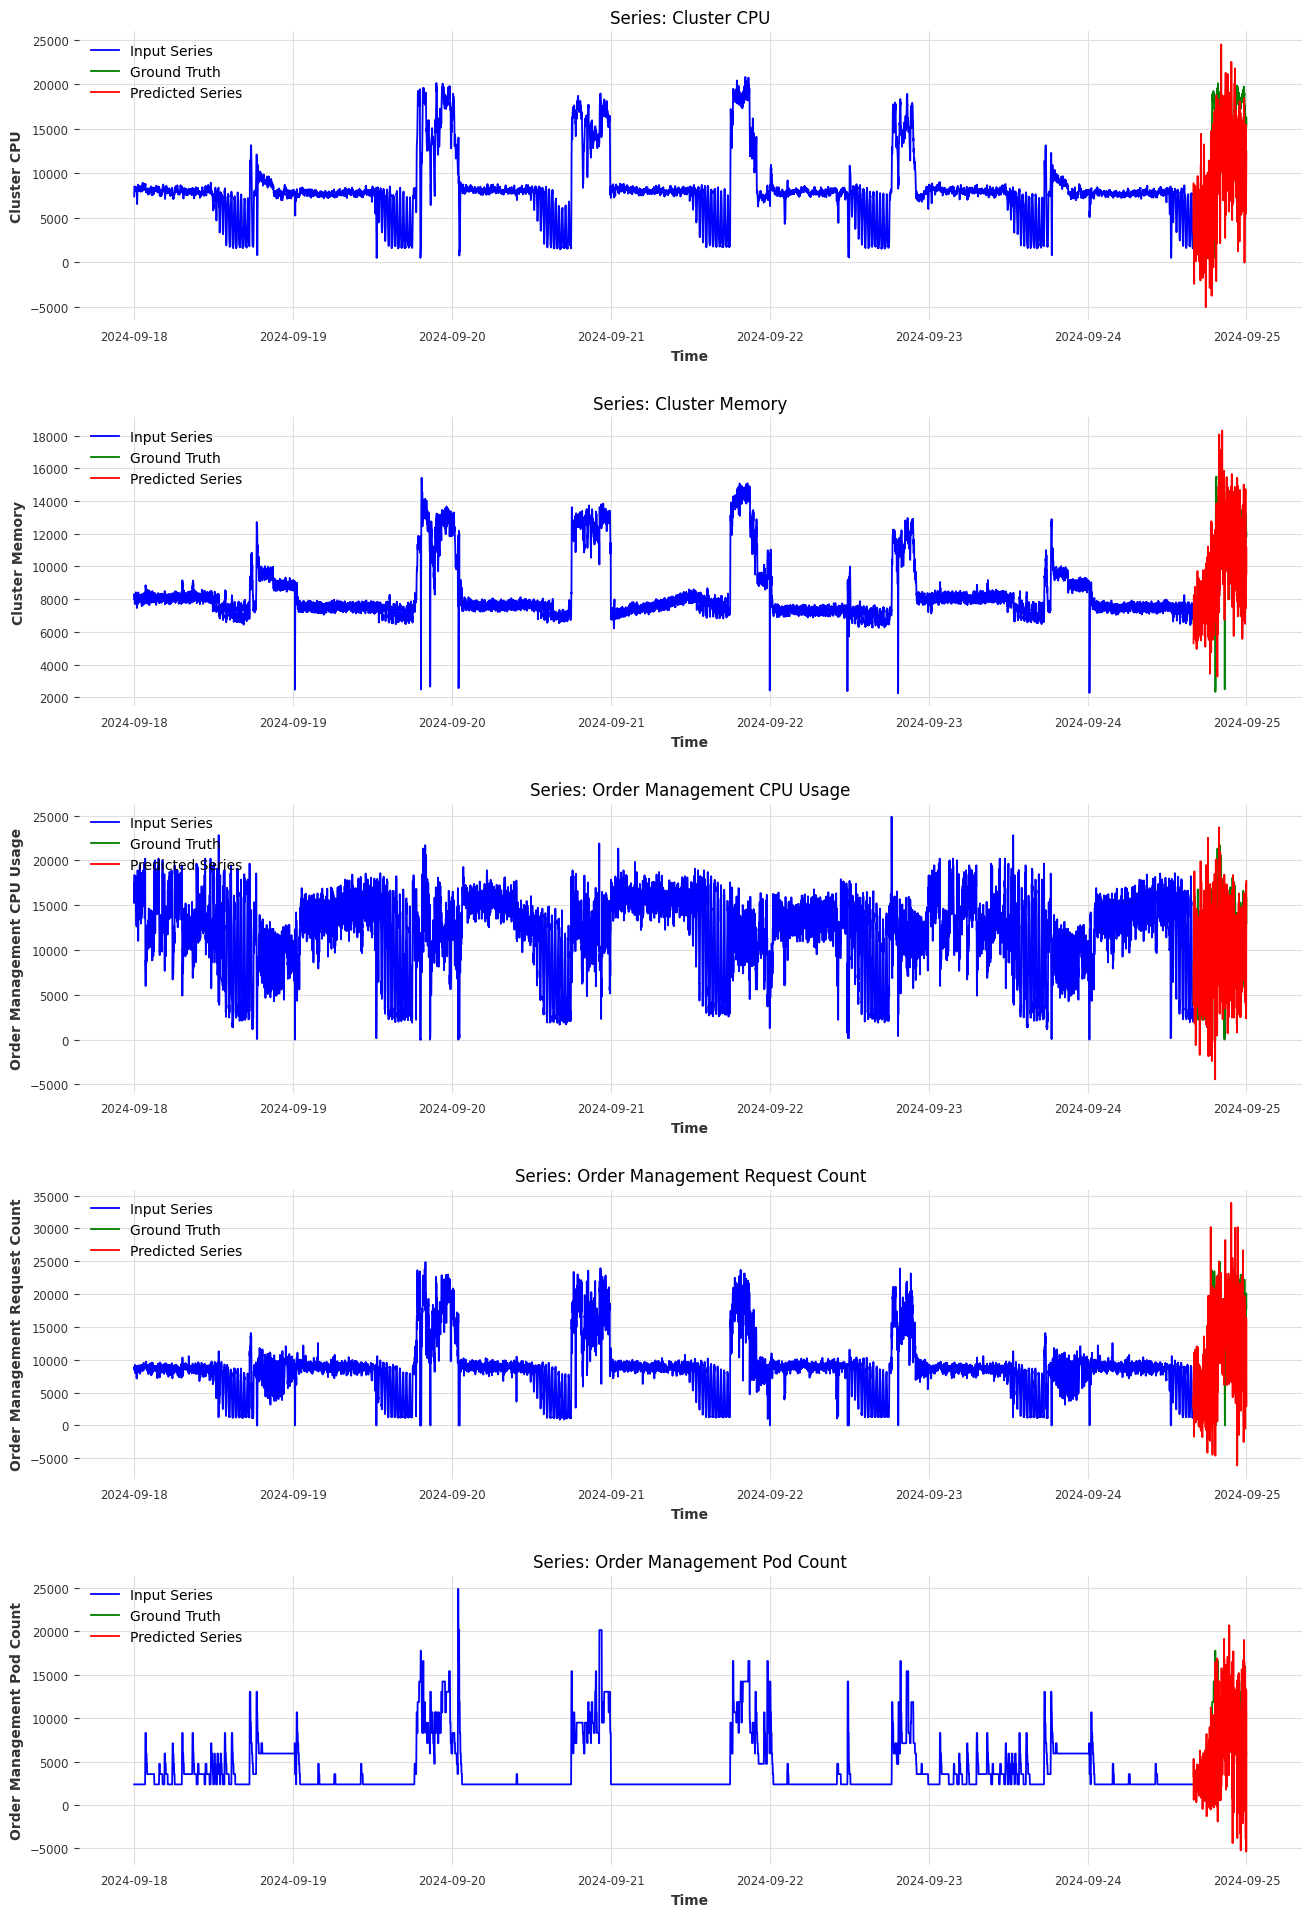

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Assume the model has been loaded
model = NHiTSModel.load(os.path.join(model_dir, "order_model.pt"))

pred_steps = 480

# Prepare the input and ground truth series
pred_input = test_series_order[:-pred_steps]  # The input data for prediction
ground_truth = test_series_order[-pred_steps:]  # The actual future data to compare against

# Predict the next `pred_steps` points using the trained model
pred_series = model.predict(n=pred_steps, series=pred_input)

# Inverse transform the series to get actual values
input_series = scaler.inverse_transform(pred_input).pd_dataframe()
ground_series = scaler.inverse_transform(ground_truth).pd_dataframe()
predicted_series = scaler.inverse_transform(pred_series).pd_dataframe()

# Define the columns to plot
columns_to_plot = [
    'Cluster CPU',
    'Cluster Memory',
    'Order Management CPU Usage',
    # 'Review Rating Memory Usage',
    'Order Management Request Count',
    # 'Review Rating 5xx Failures',
    'Order Management Pod Count'
]

# Create a 7x1 subplot to visualize the series
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 20))
fig.tight_layout(pad=5.0)

# Loop over the columns and create plots
for idx, column in enumerate(columns_to_plot):
    sns.lineplot(ax=axes[idx], x=input_series.index, y=input_series[column], label='Input Series', color='blue')
    sns.lineplot(ax=axes[idx], x=ground_series.index, y=ground_series[column], label='Ground Truth', color='green')
    sns.lineplot(ax=axes[idx], x=predicted_series.index, y=predicted_series[column], label='Predicted Series', color='red')
    
    axes[idx].set_title(f"Series: {column}")
    axes[idx].legend(loc='upper left')

# Display the plot
plt.show()
